# Experiments

> A _Pisces experiment_ is a combined specification of data sets, validation method(s), and model architectures to use.

Let's go through the example provied in `<pisces>/experiment_config/base_config.json`:
```json
{
  "data_config": {
    "data_directory": "./data_sets",
    "sets": ""
  },
  "validation": {
    "method": "LEAVE_ONE_OUT",
    "parameter": null
  },
  "models": [
    "LOGISTIC"
  ],
  "features": [
    "ACTIVITY"
  ]
}
```
Let's break this down, to give you a sense for the kinds of experiments Pisces can run and how to modify this to suit your own investigations.

* `"data_config"`: This is a dictionary that specifies the data sets to use. 
  * The `"data_directory": "./data_sets` specifies that the data sets are located in the `data_sets` directory, which is a subdirectory of the current working directory.
  * The `"sets": ""` key specifies the names of the data sets to use. Since this is an empty string, all data sets in the directory will be used. Otherwise, this would be a comma-separated list of data set names, which are folders inside the `"data_directory"` that have subdirectories matching `cleaned_*`.
* `"validation"`: This is a dictionary that specifies the validation method to use.  
  * The `"method"` key specifies the validation method to use. Here, we use `"LEAVE_ONE_OUT"`, which means that each data set will be used to train a model, and then the model will be tested on the same data set.
  * The `"parameter"` key specifies any parameters that the validation method requires. `"LEAVE_ONE_OUT"`, then the parameter is the name of the column to use for the leave-one-out validation.

In [1]:
#| default_exp evaluations

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

In [3]:
#| hide
from nbdev.showdoc import *


In [4]:
#| export

from enum import Enum
from typing import List

from enum import Enum, auto
from typing import Dict, List, Optional, Tuple, Union

from pathlib import Path

import numpy as np

In [5]:

import random
import string


def random_string(length: int) -> str:
    return ''.join(random.sample(string.ascii_lowercase, length))

ids = [
    "abx123",
    "bx887",
    "MN3f23"
]
acc_txts_1 = [
    f"{id}_cleaned_acc.txt"
    for id in ids
]

acc_txts_2 = [
    f"exported-{id}.{random_string(3)}"
    for id in ids
]

# just ID.csv, no pre/suffix
acc_txts_3 = [
    "{id}.csv"
    for id in ids
]


# just ID, no pre/suffix
acc_txts_4 = [
    "{id}"
    for id in ids
]

acc_txts = [acc_txts_1, acc_txts_2, acc_txts_3, acc_txts_4]


In [6]:
#| export

import warnings

class SimplifiablePrefixTree:
    def __init__(self, delimiter: str = "", key: str = ""):
        self.key = key
        self.children: Dict[str, SimplifiablePrefixTree] = {}
        self.is_end_of_word = False
        self.delimiter = delimiter
        self.print_spacer = ": "
    
    def chars_from(self, word: str):
        return word.split(self.delimiter) if self.delimiter else word

    def insert(self, word: str):
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                node.children[char] = SimplifiablePrefixTree(self.delimiter, key=char)
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word: str) -> bool:
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end_of_word
    
    def simplify(self):
        if len(self.children) == 1 and not self.is_end_of_word:
            child_key = list(self.children.keys())[0]
            self.key += child_key
            self.children = self.children[child_key].children
            self.simplify()
        else:
            current_keys = list(self.children.keys())
            for key in current_keys:
                child = self.children.pop(key)
                child.simplify()
                self.children[child.key] = child
        return self
    
    def reversed(self) -> 'SimplifiablePrefixTree':
        rev_self = SimplifiablePrefixTree(self.delimiter, key=self.key[::-1])
        rev_self.children = {k[::-1]: v.reversed() for k, v in self.children.items()}
        return rev_self
    
    def flattened(self, max_depth: int = 1) -> 'SimplifiablePrefixTree':
        """Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
        """
        flat_self = SimplifiablePrefixTree(self.delimiter, key=self.key)
        if max_depth == 0:
            if not self.is_end_of_word:
                warnings.warn(f"max_depth is 0, but {self.key} is not a leaf.")
            return flat_self
        if max_depth == 1:
            for k, v in self.children.items():
                if v.is_end_of_word:
                    flat_self.children[k] = SimplifiablePrefixTree(self.delimiter, key=k)
                else:
                    # flattened_children = v._pushdown()
                    for flattened_child in v._pushdown():
                        flat_self.children[flattened_child.key] = flattened_child
        else:
            for k, v in self.children.items():
                flat_self.children[k] = v.flattened(max_depth - 1)
        return flat_self
    
    def _pushdown(self) -> List['SimplifiablePrefixTree']:
        """Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
        """
        pushed_down = [
            c
            for k in self.children.values()
            for c in k._pushdown()
        ]
        for i in range(len(pushed_down)):
            pushed_down[i].key = self.key + self.delimiter + pushed_down[i].key

        if not pushed_down:
            return [SimplifiablePrefixTree(self.delimiter, key=self.key)]
        else:
            return pushed_down
            

    def __str__(self):
        # prints .children recursively with indentation
        return self.key + "\n" + self.print_tree()

    def print_tree(self, indent=0) -> str:
        result = ""
        for key, child in self.children.items():
            result +=  self.print_spacer * indent + "( " + child.key + "\n"
            result += SimplifiablePrefixTree.print_tree(child, indent + 1)
        return result



In [7]:
entries = [
    'abc123XYZ',
    'abc123XY&',
    'abc123XYA',
    'abc123XYB',
    'abc12MMVQ',
    'abc12NMVQ',
    'xy9914934',
    'xy72758',
]

tree = SimplifiablePrefixTree()
for entry in entries:
    tree.insert(entry)
print(tree)


( a
: ( b
: : ( c
: : : ( 1
: : : : ( 2
: : : : : ( 3
: : : : : : ( X
: : : : : : : ( Y
: : : : : : : : ( Z
: : : : : : : : ( &
: : : : : : : : ( A
: : : : : : : : ( B
: : : : : ( M
: : : : : : ( M
: : : : : : : ( V
: : : : : : : : ( Q
: : : : : ( N
: : : : : : ( M
: : : : : : : ( V
: : : : : : : : ( Q
( x
: ( y
: : ( 9
: : : ( 9
: : : : ( 1
: : : : : ( 4
: : : : : : ( 9
: : : : : : : ( 3
: : : : : : : : ( 4
: : ( 7
: : : ( 2
: : : : ( 7
: : : : : ( 5
: : : : : : ( 8



In [8]:
tree = tree.simplify()
print(tree)


( abc12
: ( 3XY
: : ( Z
: : ( &
: : ( A
: : ( B
: ( MMVQ
: ( NMVQ
( xy
: ( 9914934
: ( 72758



In [9]:
print(tree.flattened(3))


( abc12
: ( 3XY
: : ( Z
: : ( &
: : ( A
: : ( B
: ( MMVQ
: ( NMVQ
( xy
: ( 9914934
: ( 72758



In [10]:
#| export

import os
import re
import polars as pl
from typing import DefaultDict, Iterable
from collections import defaultdict
import logging

from pisces.utils import determine_header_rows_and_delimiter

LOG_LEVEL = logging.INFO

class DataSetObject:
    FEATURE_PREFIX = "cleaned_"

    # Set up logging
    logger = logging.getLogger(__name__)
    logger.setLevel(LOG_LEVEL)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    def __init__(self, name: str, path: Path):
        self.name = name
        self.path = path
        self.ids: List[str] = []

        # keeps track of the files for each feature and user
        self._feature_map: DefaultDict[str, Dict[str, str]] = defaultdict(dict)
        self._feature_cache: DefaultDict[str, Dict[str, pl.DataFrame]] = defaultdict(dict)
    
    @property
    def features(self) -> List[str]:
        return list(self._feature_map.keys())
    
    def __str__(self):
        return f"{self.name}: {self.path}"

    def get_feature_data(self, feature: str, id: str) -> pl.DataFrame | None:
        if feature not in self.features:
            warnings.warn(f"Feature {feature} not found in {self.name}. Returning None.")
            return None
        if id not in self.ids:
            warnings.warn(f"ID {id} not found in {self.name}")
            return None
        if (df := self._feature_cache[feature].get(id)) is None:
            file = self.get_filename(feature, id)
            self.logger.debug(f"Loading {file}")
            try:
                n_rows, delimiter = determine_header_rows_and_delimiter(file)
                # self.logger.debug(f"n_rows: {n_rows}, delimiter: {delimiter}")
                df = pl.read_csv(file, has_header=True if n_rows > 0 else False,
                                 skip_rows=max(n_rows-1, 0), 
                                 separator=delimiter)
            except Exception as e:
                warnings.warn(f"Error reading {file}:\n{e}")
                return None
            self._feature_cache[feature][id] = df
        return df

    def get_filename(self, feature: str, id: str) -> Path:
        return self.get_feature_path(feature)\
            .joinpath(self._feature_map[feature][id])
    
    def get_feature_path(self, feature: str) -> Path:
        return self.path.joinpath(self.FEATURE_PREFIX + feature)
    
    def _extract_ids(self, files: List[str]) -> List[str]:
        ids_in_files_rev = SimplifiablePrefixTree()
        for file in files:
            ids_in_files_rev.insert(file[::-1])
        return [
            c.key for c in ids_in_files_rev
                .simplify()
                .reversed()
                .flattened(1)
                .children
                .values()
        ]
    
    def add_feature_files(self, feature: str, files: Iterable[str]):
        if feature not in self.features:
            self.logger.debug(f"Adding feature {feature} to {self.name}")
            self._feature_map[feature] = {}
        deduped_ids = set(self.ids)
        for id, file in zip(self._extract_ids(files), files):
            self._feature_map[feature][id] = file
            deduped_ids.add(id)
        self.ids = sorted(list(deduped_ids))
    
    def get_feature_files(self, feature: str) -> Dict[str, str]:
        return {k: v for k, v in self._feature_map[feature].items()}
    
    def get_id_files(self, id: str) -> Dict[str, str]:
        return {k: v[id] for k, v in self._feature_map.items()}
    
    def load_feature_data(self, feature: str | None, id: str | None) -> Dict[str, np.ndarray]:
        if feature not in self.features:
            raise ValueError(f"Feature {feature} not found in {self.name}")
    
    @classmethod
    def find_data_sets(cls, root: str | Path) -> Dict[str, 'DataSetObject']:
        set_dir_regex = r".*" + cls.FEATURE_PREFIX + r"(.+)"
        # this regex matches the feature directory name and the data set name
        # but doesn't work on Windows (? maybe, cant test) because of the forward slashes
        feature_dir_regex = r".*/(.+)/" + cls.FEATURE_PREFIX + r"(.+)"

        data_sets: Dict[str, DataSetObject] = {}
        for root, dirs, files in os.walk(root):
            # check to see if the root is a feature directory,
            # if it is, add that feature data to the data set object,
            # creating a new data set object if necessary.
            if (root_match := re.match(feature_dir_regex, root)):
                cls.logger.debug(f"Feature directory: {root}")
                cls.logger.debug(f"data set name: {root_match.group(1)}")
                cls.logger.debug(f"feature is: {root_match.group(2)}", )
                data_set_name = root_match.group(1)
                feature_name = root_match.group(2)
                if (data_set := data_sets.get(data_set_name)) is None:
                    data_set = DataSetObject(root_match.group(1), Path(root).parent)
                    data_sets[data_set.name] = data_set
                data_set.add_feature_files(feature_name, files)
        
        return data_sets
    



In [11]:
sets = DataSetObject.find_data_sets("../data_sets")

In [12]:
w = sets['walch_et_al']

In [13]:

from sklearn.linear_model import LinearRegression, SGDClassifier
import numpy as np

# X is your input data, a 2D array where each row is a sample and each column is a feature
# y is your output data, a 1D array of target values
X = np.random.rand(8, 3)
y = np.random.rand(8, 2)

model = LinearRegression()
model.fit(X, y)

# The coefficients
print('Coefficients: \n', model.coef_)
# The intercept
print('Intercept: \n', model.intercept_)

Coefficients: 
 [[ 0.00744478 -0.00917287  0.57292693]
 [-0.19228752 -0.23472175  0.63706178]]
Intercept: 
 [0.49755603 0.46654027]


In [27]:
from numpy.lib.stride_tricks import as_strided

def psg_to_sleep_wake(psg: pl.DataFrame) -> np.array:
    # map all positive classes to 1 (sleep)
    # retain all 0 (wake) and -1 (mask) classes
    return np.where(psg[:, 1] > 0, 1, psg[:, 1])

def get_activity_X_PSG_y(data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray]:
    activity_0 = data_set.get_feature_data("activity", id)
    psg_0 = data_set.get_feature_data("psg", id)

    # trim the activity and psg data to both end when the 0th column (time) of either ends
    end_time = min(activity_0[-1, 0], psg_0[-1, 0])
    rows_retained = sum(activity_0[:, 0] <= end_time)
    activity_0 = activity_0.filter(activity_0[:, 0] <= end_time)
    psg_0 = psg_0.filter(psg_0[:, 0] <= end_time)

    X = activity_0[:, 1].to_numpy()
    # make the reshape(-1, 2) non-ragged 
    # remove the last element if the length is odd
    if res := X.shape[0] % 2:
        #! X[:-0] is empty, so don't do this if res == 0
        X = X[:-res] 
    X = X.reshape((-1, 2)).sum(axis=1)
    y = psg_to_sleep_wake(psg_0)

    return X, y

def rolling_window(arr, window_size):
    strided_axis_0 = max(arr.shape[0] - window_size + 1, 0)
    arr_strided = as_strided(arr, shape=(strided_axis_0, window_size), strides=(arr.strides[0], arr.strides[0]))
    return arr_strided

In [28]:
print(rolling_window(np.arange(10), 3))

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]


In [36]:
from sklearn.metrics import roc_auc_score


class SleepWakeClassifier:
    """Eventually, will be the base class. But for now, it will be the only example and it's logistic regression.

    That is, this has a matrix A of shape (n_examples, n_features) and a 'bias' vector b of shape (n_examples, 1).

    This model then learns A and b to optimize model.predict(x) = sigmoid(A @ x + b), where x is the input.
    
    """
    def __init__(self, lr: float = 0.15, input_dim: int = 11, output_dim: int = 1):
        self.model = SGDClassifier(loss='log_loss',
                                   learning_rate='adaptive',
                                   eta0=lr,
                                   warm_start=True,
                                   class_weight='balanced')
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.window_step = 1

    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        if examples_X or examples_y:
            assert len(examples_X) == len(examples_y)
        if pairs_Xy:
            assert not examples_X
        
        training = []
        training_iterator = iter(pairs_Xy) if pairs_Xy else zip(examples_X, examples_y)
        for X, y in training_iterator:
            try:
                X_folded = self._fold(X)
                y_trimmed = self._trim_labels(y)
                if (X_folded.shape[0] != y_trimmed.shape[0]) \
                    or (X_folded.shape[0] == 0) \
                    or (y_trimmed.shape[0] == 0):
                    # warnings.warn(f"Skipping data with shape 0")
                    continue
                training.append((X_folded, y_trimmed))
            except Exception as e:
                print(f"Error folding or trimming data: {e}")
                continue

        for i in range(epochs):
            for X, y in training:
                if (X.shape[0] != y.shape[0]) or (X.shape[0] == 0) or (y.shape[0] == 0):
                    print(f"epoch {i} shape 0")
                    continue
                n_sleep = np.sum(y > 0)
                n_wake = np.sum(y == 0)
                N = n_sleep + n_wake
                # Want to make a balanced weight loss, along with giving 0.0 * loss for masked values (y < 0)
                mask_weights_zero = np.where(y < 0, 0.0, 1)
                balancing_weights_ignore_mask = np.where(y > 0, n_wake / N, n_sleep / N)
                sample_weights = mask_weights_zero * balancing_weights_ignore_mask

                y_demasked = np.where(y < 0, 0, y)


                self.model.partial_fit(X, y_demasked,
                                       classes=[0, 1], 
                                       sample_weight=sample_weights)
    
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict(self._fold(sample_X))
    
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict_proba(self._fold(sample_X))

    def evaluate(self, examples_X_y: Tuple[np.ndarray, np.ndarray], method: str = 'auc') -> float:
        trimmed_labels = self._trim_labels(examples_X_y[1])

        if method == 'accuracy':
            prediction = self.predict(examples_X_y[0])
            return np.mean(prediction == trimmed_labels)
        elif method == 'auc':
            # get probability of sleep
            prediction = self.predict_probabilities(examples_X_y[0])[:, -1]
            # drop all -1 (mask) classes
            min_matching_length = min(len(trimmed_labels), len(prediction))
            prediction = prediction[:min_matching_length]
            trimmed_labels = trimmed_labels[:min_matching_length]
            non_mask = trimmed_labels >= 0
            prediction = prediction[non_mask]
            trimmed_labels = trimmed_labels[non_mask]
            auc = roc_auc_score(trimmed_labels, prediction)
            # print(f"AUC: {auc}")
            return auc


    def _fold(self, input_X: np.ndarray | pl.DataFrame) -> np.array:
        if isinstance(input_X, pl.DataFrame):
            xa = input_X.to_numpy()
        return rolling_window(input_X, self.input_dim)
    
    def _trim_labels(self, labels_y: pl.DataFrame) -> np.ndarray:
        start, end = self._indices_to_trim()
        return labels_y[start:-end]
        
    def _indices_to_trim(self) -> Tuple[int, int]:
        # ex: input_dim = 8 => (4, 3)
        # ex: input_dim = 7 => (3, 3)
        # ex: input_dim = 6 => (3, 2)
        return (self.input_dim // 2, self.input_dim - (self.input_dim // 2))


In [37]:
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
train_indices, test_indices = [], []

def run_split(train_index, test_index, preprocessed_data_set
              ) -> Tuple[SleepWakeClassifier, 
                         List[Tuple[np.ndarray, np.ndarray]]]:
    swc = SleepWakeClassifier()
    training_pairs = [preprocessed_data_set[i] for i in train_index]
    swc.train(pairs_Xy=training_pairs, epochs=100)

    testing_pairs = [preprocessed_data_set[i] for i in test_index]

    return swc#, [(swc.predict(X), y) for X, y in testing_pairs]

split_models: List[SleepWakeClassifier] = []
test_indices = []

preprocessed_data = [get_activity_X_PSG_y(w, i) for i in w.ids]

i = 0
for train_index, test_index in tqdm(loo.split(w.ids)):
    try:
        model = run_split(train_index, test_index, preprocessed_data_set=preprocessed_data)
        split_models.append(model)
        test_indices.append(test_index[0])
    except:
        print(test_index[0], w.ids[test_index[0]],"failed testing")
    i += 1
    # if i >= 2:
    #     break


31it [00:12,  2.44it/s]


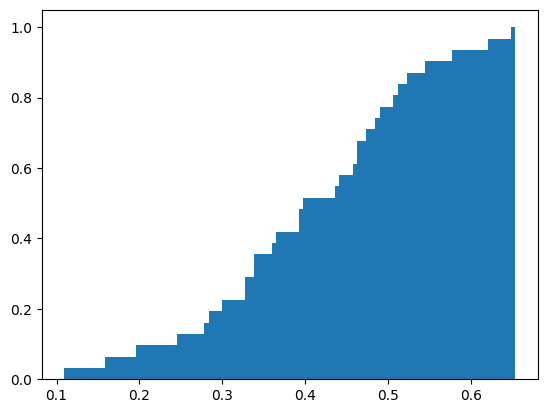

In [45]:
import matplotlib.pyplot as plt
aucs = [split_models[i].evaluate(preprocessed_data[test_indices[i]]) for i in range(len(test_indices))]
_ = plt.hist(aucs, cumulative=True, density=True,bins=100)